In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch

In [4]:
import albumentations as A
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms.functional as TF
from tqdm import tqdm
import torch.optim as optim
import os

In [5]:
data_8 = "/content/drive/MyDrive/DL_project/8jap+1eng_col_caps_test_new/"

In [6]:
# import os
# os.path.join(data_8_train, 'train')
#os.listdir(os.path.join(data_8_train, 'train'))

In [7]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [8]:
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

def get_transforms(img_height, img_width):
    ###################################DATA AUGMENTATIONS###############################
    train_transform = A.Compose(
            [
                A.Resize(img_height,img_width),
                A.Normalize(mean=[0,0,0],std=[1,1,1]),
                A.Flip(),
                A.Rotate(limit=(-90, 90)),
                A.ColorJitter(0.08, 0.20),
                #A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                #A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
                ToTensorV2(),
            ],
        )

    val_transform = A.Compose(
            [
                ### START YOUR CODE HERE
                A.Resize(img_height,img_width),
                A.Normalize(mean=[0,0,0],std=[1,1,1]),
                ### END YOUR CODE HERE
                ToTensorV2(),
            ],
        )
    ###################################################################################

    return train_transform, val_transform


In [9]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

  # Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [10]:
import torch
from torch.utils.data import Dataset
import os
import cv2 as cv
from PIL import Image
import numpy as np

class ImgDataset(Dataset):
    def __init__(self, dir, train= False, transform=None):
        """
        Initialize the segmentation dataset.

        Args:
            dir (str): The path to the data directory containing both images and masks.
            transform (callable): A function/transform to apply to the data.
        """
        folder = ""
        if train:
          folder = "train"
        else:
          folder = "test"
        self.image_dir = os.path.join(dir, 'A/' + folder +"/")
        self.transform = transform
        self.images = os.listdir(self.image_dir)

    def __len__(self):
        """
        Return the size of the dataset.

        Returns:
            int: The number of samples in the dataset.

        """
        #### START YOUR CODE HERE
        return len(self.images)
        ### END YOUR CODE HERE


    def __getitem__(self, idx):
        """
        Retrieve and preprocess an image and its corresponding mask.
        Image: (3, 512, 512)
        Mask: (3, 512, 512)

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the preprocessed image and its corresponding mask.
                - image (Tensor): The preprocessed image as a PyTorch tensor.
                - mask (Tensor): The preprocessed mask as a PyTorch tensor.
        """
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(img_path.replace("A", "B"))

        #### START YOUR CODE HERE
        image = cv.imread(img_path)
        #image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        mask = cv.imread(mask_path)




        t = self.transform(mask = mask, image = image)
        new_mask = t["mask"]
        new_image = t["image"]


        max = torch.max(new_image)
        min = torch.min(new_image)
        maxmin = max - min
        new_image = (new_image - min)/maxmin

        max = torch.max(new_mask)
        min = torch.min(new_mask)
        maxmin = max - min
        new_mask = (new_mask - min)/maxmin

        ### END YOUR CODE HERE

        return new_image, new_mask

In [11]:

img_height=img_width=512
batch_size=8
train_dir=data_8 #Enter the path to your train data
test_dir=data_8  #Enter the path to your test data
####################################################################################

###################################DATA AUGMENTATIONS###############################
train_transform, val_transform=get_transforms(img_height, img_width)
###################################################################################

###################################DATALOADERS#####################################
train_ds = ImgDataset(
        dir=train_dir,
        train = True,
        transform=train_transform,
    )

val_ds = ImgDataset(
        dir = test_dir,
        transform=val_transform,
    )

train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=1,
        shuffle=True,
    )


val_loader = DataLoader(
      val_ds,
      batch_size=batch_size,
      num_workers=1,
      shuffle=False,
  )


torch.Size([8, 3, 512, 512]) torch.Size([8, 512, 512, 3])


TypeError: ignored

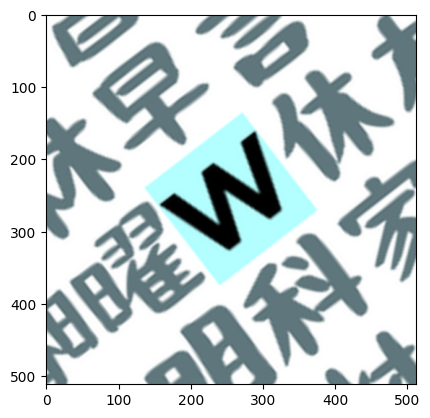

In [12]:
image, mask = next(iter(train_loader))


torch.Size([8, 3, 512, 512]) torch.Size([8, 512, 512, 3])


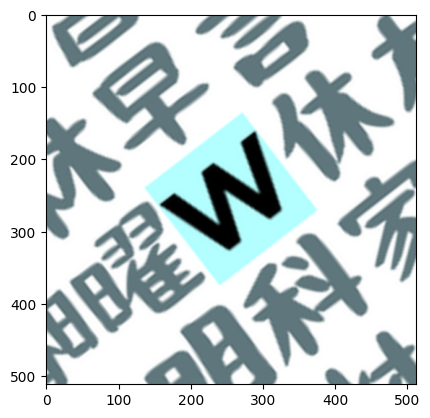

In [16]:
print(image.shape, mask.shape)
plt.imshow(np.array(image[1].permute(1, 2, 0)))

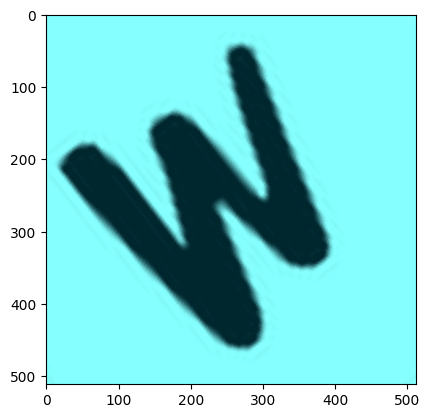

In [17]:
plt.imshow(np.array(mask[1].permute(0, 1, 2)))